In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: June 12, 2019
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter
from skimage.measure import compare_ssim as ssim

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image
import scipy
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras.layers import Input
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import Callback
from keras.losses import mean_squared_error
from keras.utils.np_utils import to_categorical
from keras.models import Model

from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

VGG16_DANN256 = load_model('./tmp/RefineMask_DANN256.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'GradientReversal':NeMO_layers.GradientReversal, 'charbonnierLoss': charbonnierLoss})

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Warning! Truth image not in expected format... loading directly whole image using cv2...
(256, 256, 4)


<IPython.core.display.Javascript object>


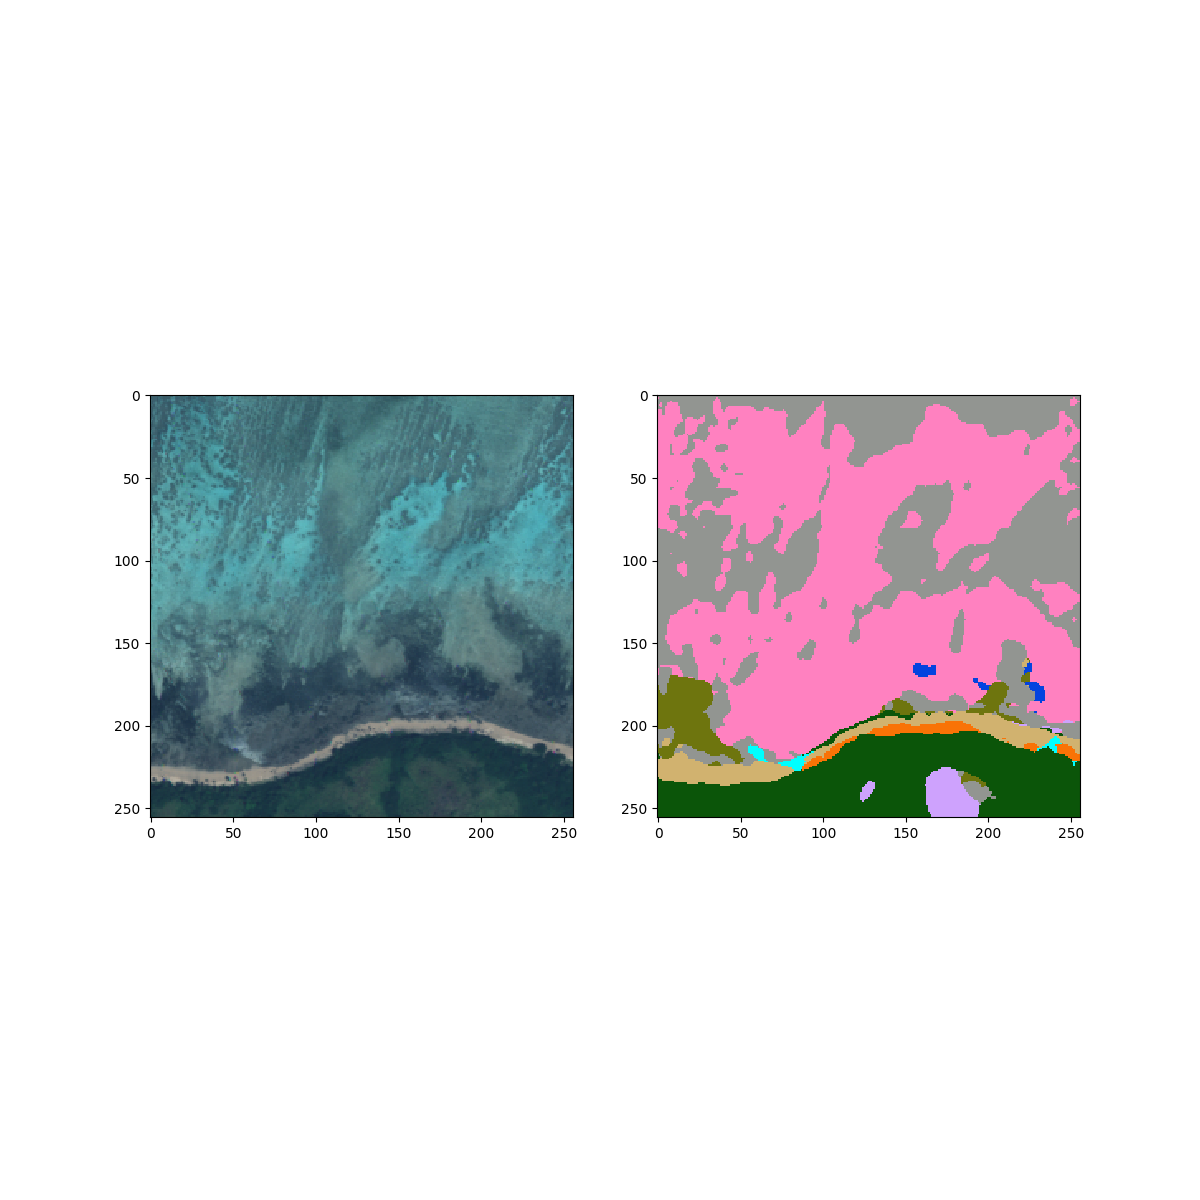

In [22]:
# VGG16_DANN256.summary()

# source_inputs = Input(shape=source_input_shape)
#  = VGG16_DANN256.get_layer("model_4").get_input_at(0)

# Output = VGG16_DANN256.get_layer("model_3").get_output_at(0)
# classifier_input = Input(VGG16_DANN256.get_layer("model_4").input_shape[1:])

# Classifier = Model(VGG16_DANN256., Output)

# imgpath = '/home/asli/NeMO-Test/NeMO-NET/Images/Jarrett_Training_Patches/Coral/Coral_00000007.tif'
# imgpath = '/home/asli/NeMO-Test/NeMO-NET/Images/CiciaDANN_Target_256/Coral/Coral_00000092.tif'
truthpath = '/home/asli/NeMO-Test/NeMO-NET/Images/Jarrett_TrainingRef_Patches/Coral/Coral_00000002.png'

jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

TestImg = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
TestImg.testimage = TestImg.image[:,:,:]
TestImg.testimage = np.delete(TestImg.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR
print(np.shape(TestImg.testimage))

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v

TestImg.set_mean_std(0,1)
testoutput = VGG16_DANN256.predict(np.expand_dims(TestImg.testimage,axis=0))
# whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
#     TestImg.predict_on_whole_image(VGG16_DANN256, image_size = 256, num_classes = len(class_indices_rev), spacing = (1,1), predict_size = 256, num_lines=None, lastchannelremove=False)

# print(testoutput[0].shape, testoutput[1].shape)
predictions = np.reshape(np.argmax(testoutput[0][0],-1), (256,256))
fig = plt.figure(1,figsize=(12,12))

patch_R = 100*TestImg.testimage[:,:,2]+100
patch_G = 100*TestImg.testimage[:,:,1]+100
patch_B = 100*TestImg.testimage[:,:,0]+100
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
ax = plt.subplot(121)
ax.imshow(np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3))

ax = plt.subplot(122)
ax.imshow(predictions.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()

<IPython.core.display.Javascript object>


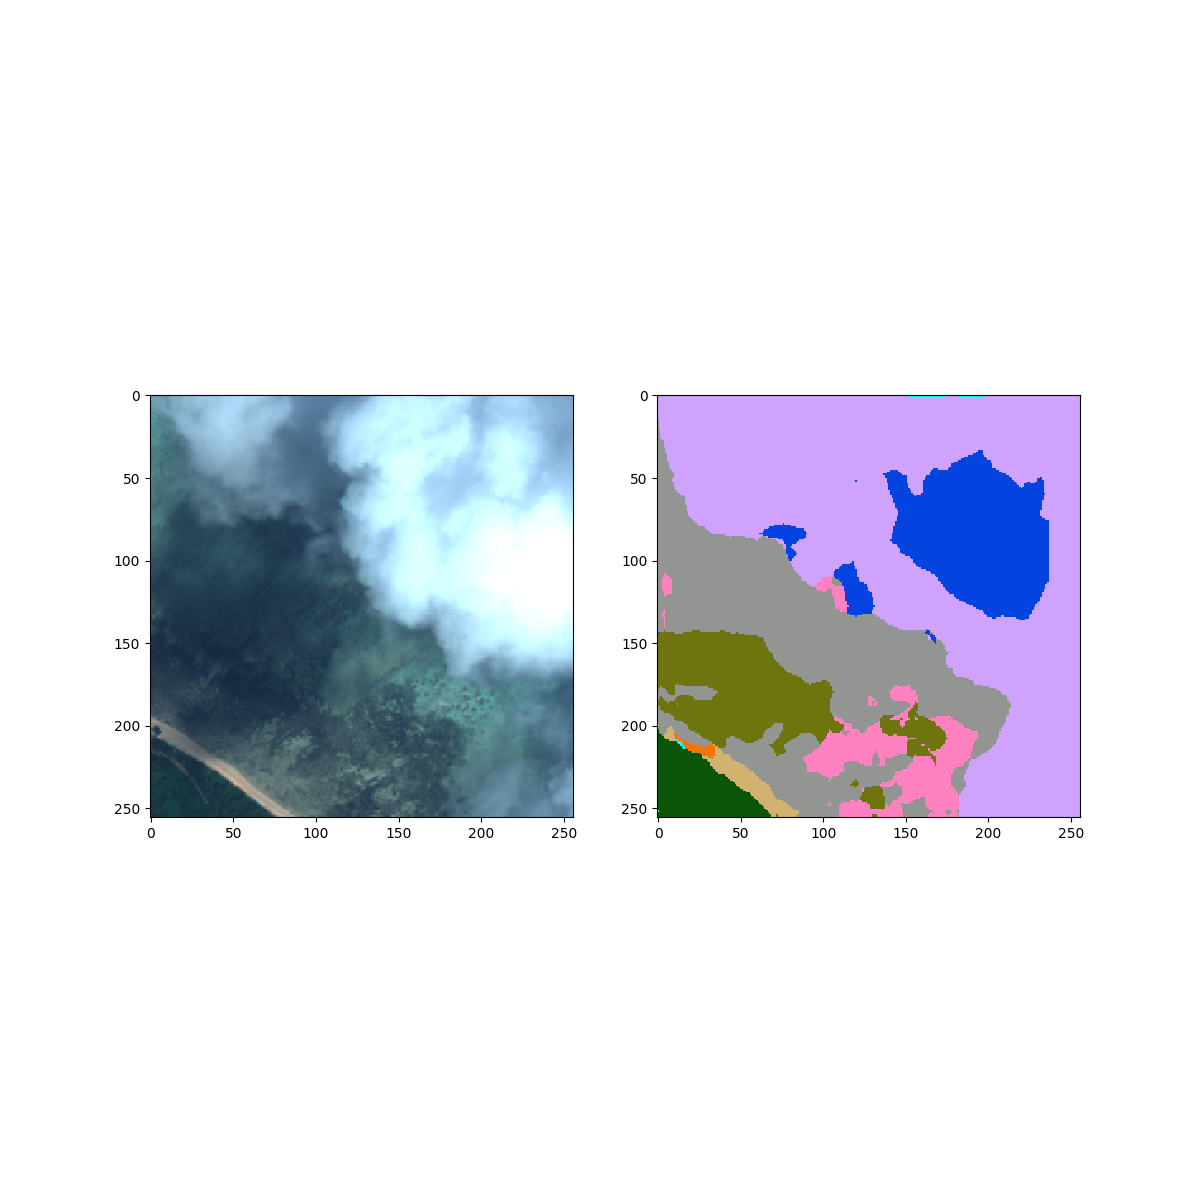